# RL Assignment 1

In [1]:
# Install the required packages
!pip install gymnasium matplotlib numpy pandas==

ERROR: Could not find a version that satisfies the requirement pandas== (from versions: 0.1, 0.2, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0, 0.21.1, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.24.0, 0.24.1, 0.24.2, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5, 1.4.0rc0, 1.4.0, 1.4.1, 1.4.2, 1.4.3, 1.4.4, 1.5.0rc0, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 2.0.0rc0, 2.0.0rc1, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.1.0rc0, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0)
ERROR: No matching distribution found for pandas==


## Part 1: Defining RL Environments

In [2]:
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from enum import Enum
import pickle

/var/folders/nx/7cy8wjn91wz5trfd0myjdwx40000gn/T/ipykernel_19949/2338546522.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1.1: Deterministic Environment

In [3]:
# Action ENUM
class Action(Enum):
    DOWN = 0
    UP = 1
    RIGHT = 2
    LEFT = 3

In [4]:
"""
Definition of the Grid Env class.

References: RL Env Creation and Random Agent Demo
"""
class DeterministicGridEnv(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self, rows, cols, max_timesteps, start_pos, goal_pos, rewards_map):

      self.observation_space = spaces.Discrete(rows*cols)
      self.action_space = spaces.Discrete(4)
      self.max_timesteps = max_timesteps
      self.rows = rows
      self.cols = cols
      self.start_pos = start_pos
      self.goal_pos = goal_pos
      self.rewards_map = rewards_map

      self.timestep = 0
      self.reset()

    # Reset function
    def reset(self):
      self.state = np.zeros((self.rows, self.cols))
      self.agent_pos = self.start_pos.copy()
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()
      self.timestep = 0

      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      next_pos = self.agent_pos.copy()

      if action == Action.DOWN.value:
        next_pos[0] += 1
      elif action == Action.UP.value:
        next_pos[0] -= 1
      elif action == Action.RIGHT.value:
        next_pos[1] += 1
      elif action == Action.LEFT.value:
        next_pos[1] -= 1

      if 0 <= next_pos[0] < self.rows and 0 <= next_pos[1] < self.cols:
        self.agent_pos = next_pos

      self.state = np.zeros((self.rows, self.cols))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()
      info = {}

      # check rewards map for reward
      reward = -1
      if tuple(self.agent_pos) in self.rewards_map:
        reward = self.rewards_map[tuple(self.agent_pos)]

      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if ((self.timestep >= self.max_timesteps) or np.array_equal(self.agent_pos, self.goal_pos)) else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = False if (0 <= self.agent_pos[0] < self.rows and 0 <= self.agent_pos[1] < self.cols) else True
      
      return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self):
      plt.figure()
      plt.title('Grid Environment')
      plt.imshow(self.state)
  

In [5]:
"""
Definition an agent that takes action randomly

References: RL Env Creation and Random Agent Demo
"""
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    """Takes a step in the environment by choosing an action randomly.

    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    return self.env.action_space.sample()

In [6]:
# Define 4 rewards for the agent to collect
rewards_map = {
    (0, 1): 1,
    (2, 1): -2,
    (1, 3): 3,
    (2, 3): 10
}

# Initialize the environment
d_env = DeterministicGridEnv(3, 4, 10, [0, 0], [2, 3], rewards_map)

# Initialize the agent
agent = RandomAgent(d_env)

Timestep: 1 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 2 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 3 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: 1
Timestep: 4 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 5 , State: [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 6 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 7 , State: [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 8 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 9 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 10 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: LEFT , Reward: -1


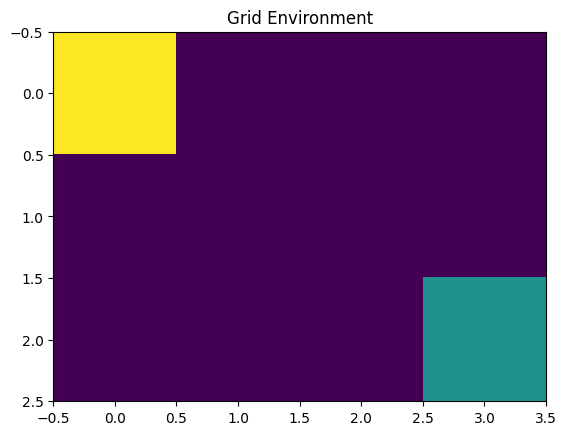

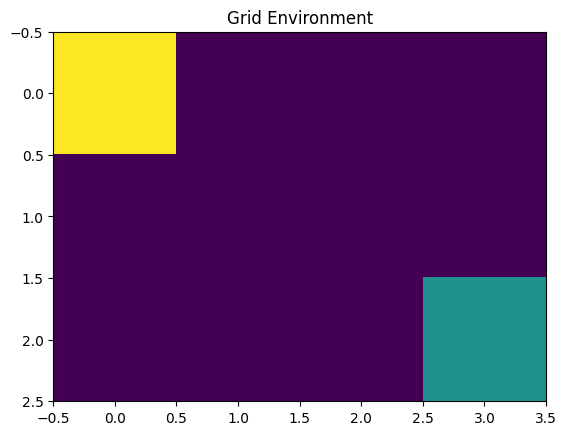

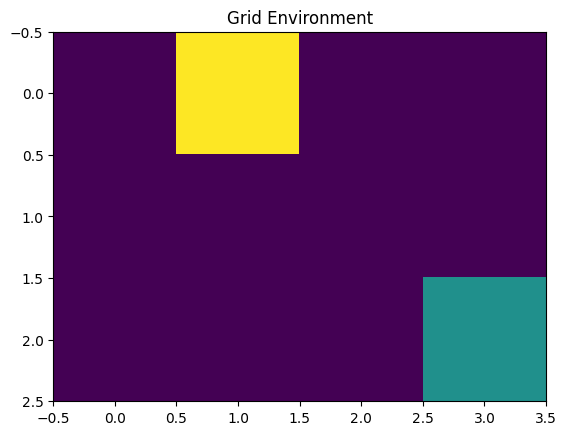

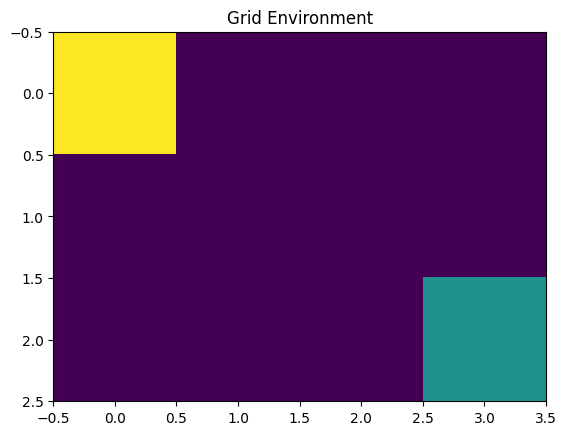

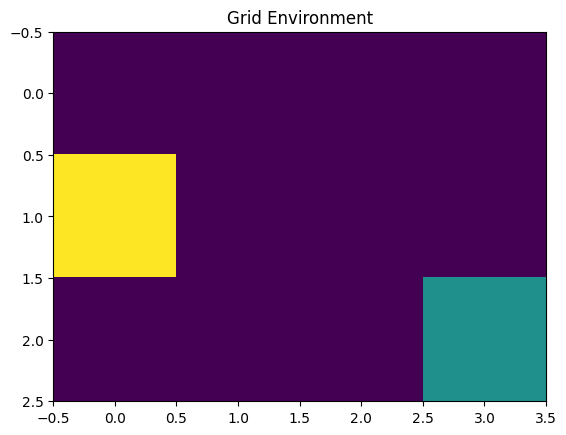

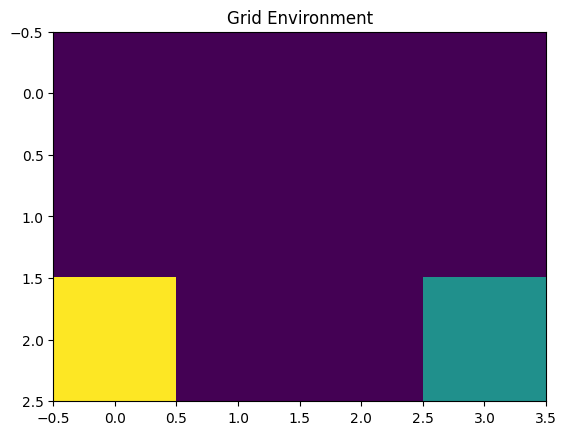

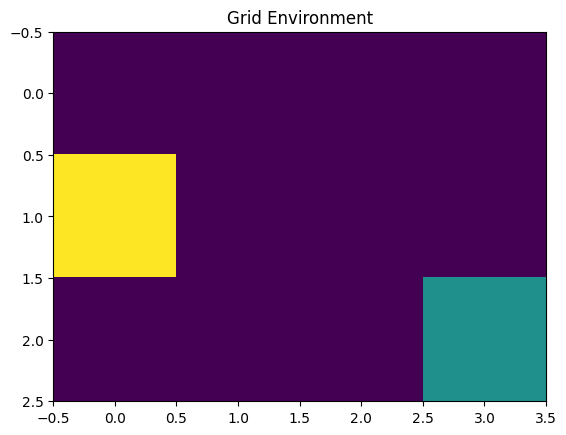

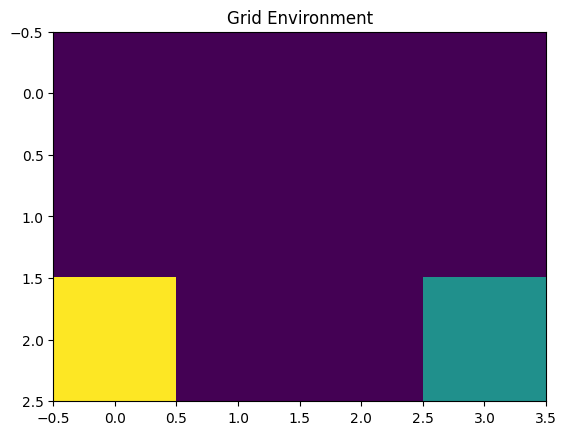

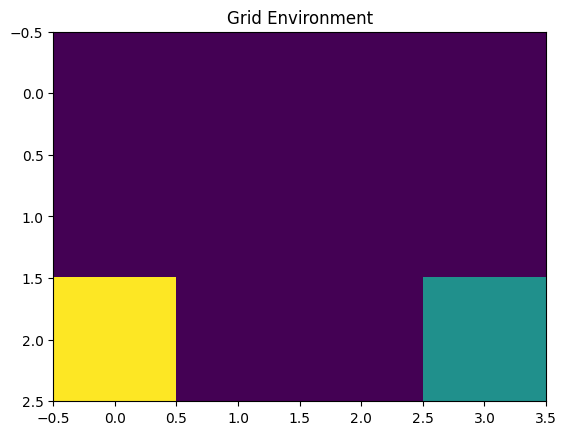

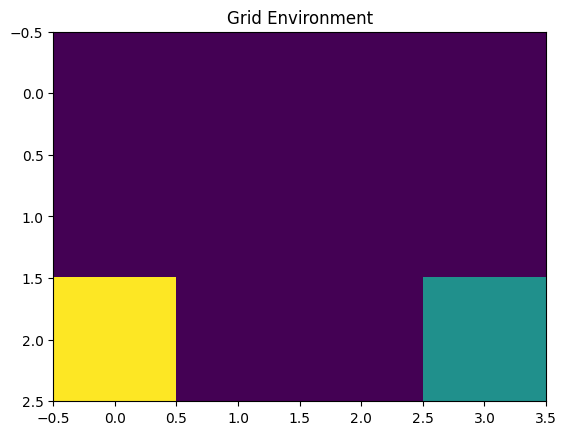

In [7]:
obs, info = d_env.reset()
terminated, truncated = False, False

for _ in range(10):
    action = agent.step(obs)
    obs, reward, terminated, truncated, info = d_env.step(action)
    print('Timestep:', d_env.timestep, ', State:', obs, ', Action:', Action(action).name, ', Reward:', reward)
    d_env.render()

### Part 1.2: Stochastic Environment

In [8]:
"""
Definition of the Stochastic Grid Env class.
Extend the DeterministicGridEnv class to include stochasticity in the environment.
"""
class StochasticGridEnv(DeterministicGridEnv):
  def __init__(self, rows, cols, max_timesteps, agent_pos, goal_pos, rewards_map, p_stochastic):
    super().__init__(rows, cols, max_timesteps, agent_pos, goal_pos, rewards_map)
    self.p_stochastic = p_stochastic

  def step(self, action):
    if np.random.rand() < self.p_stochastic:
      action = self.action_space.sample()

    return super().step(action)

In [9]:
# Define 4 rewards for the agent to collect
rewards_map = {
    (0, 1): 1,
    (2, 1): -2,
    (1, 3): 3,
    (2, 3): 10
}

# Initialize the environment
s_env = StochasticGridEnv(3, 4, 10, [0, 0], [2, 3], rewards_map, 0.1)

# Initialize the agent
agent = RandomAgent(s_env)

Timestep: 1 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 2 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 3 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 4 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: 1
Timestep: 5 , State: [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 6 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: 1
Timestep: 7 , State: [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: -1
Timestep: 8 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: 1
Timestep: 9 , State: [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 10 , State: [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.5] , Action: DOWN , Reward: -2


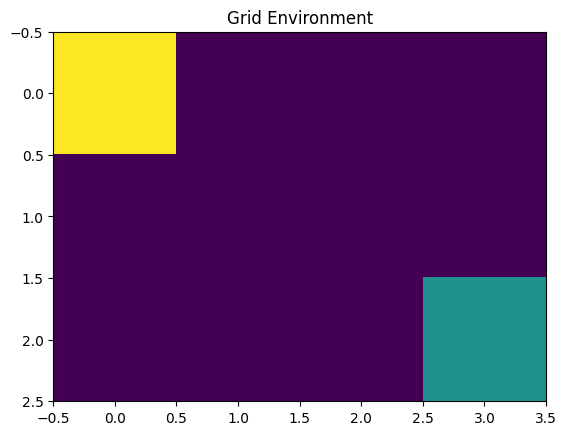

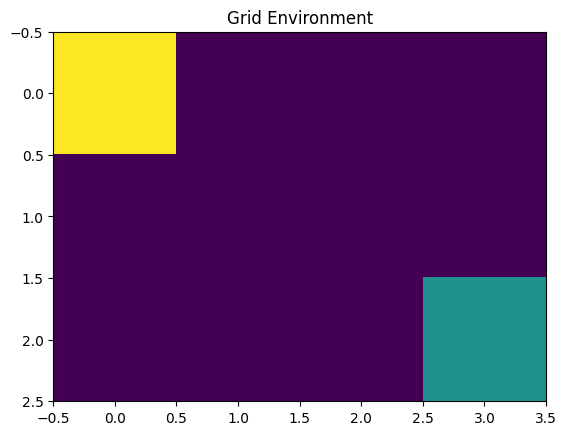

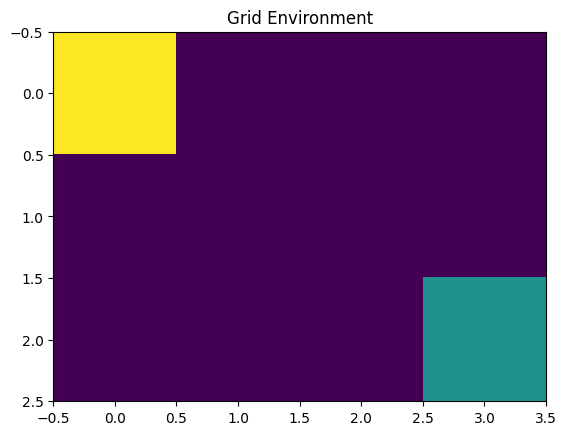

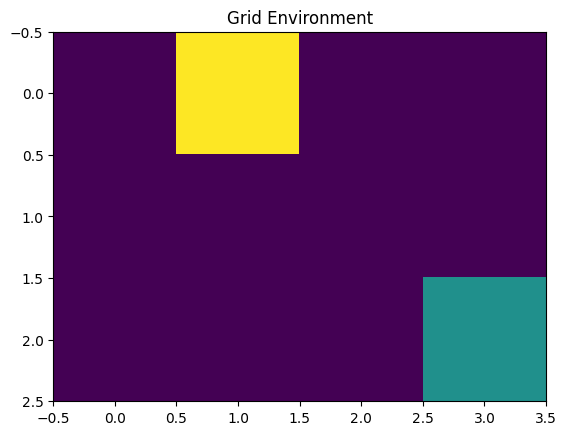

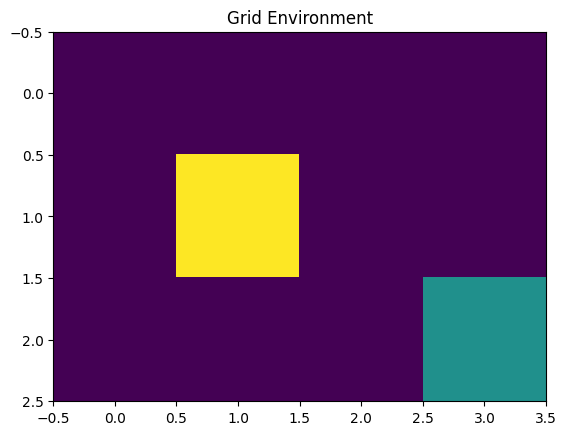

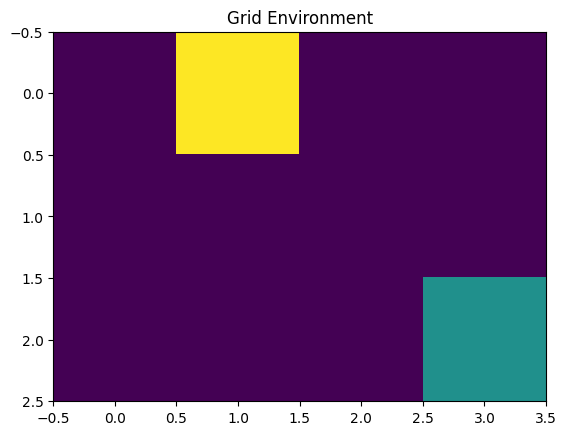

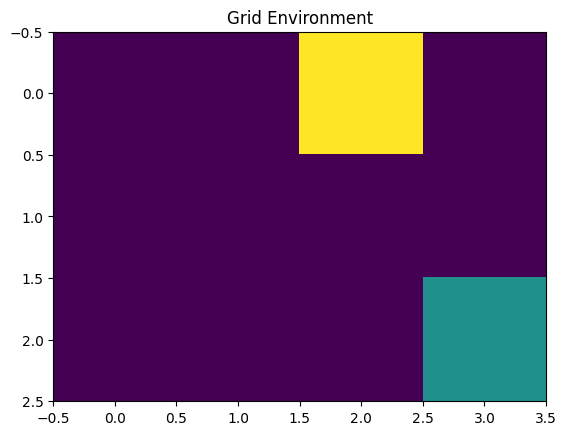

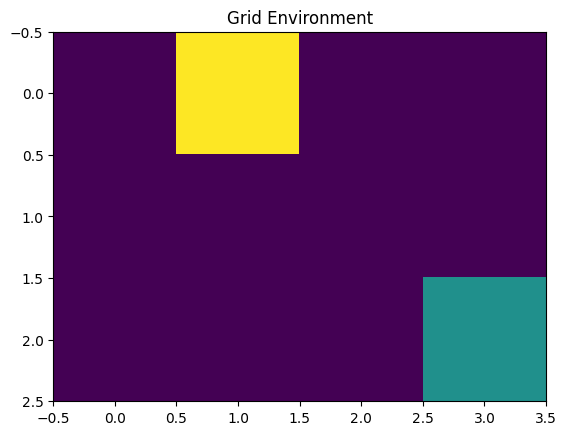

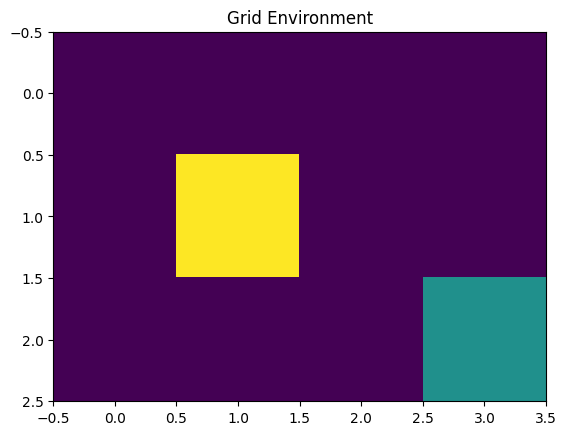

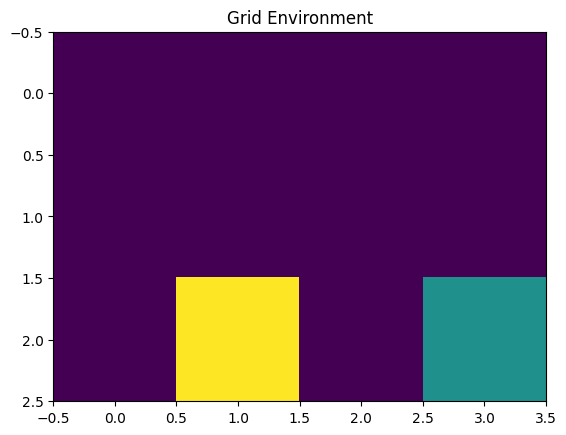

In [10]:
obs, info = s_env.reset()
terminated, truncated = False, False

for _ in range(10):
    action = agent.step(obs)
    obs, reward, terminated, truncated, info = s_env.step(action)
    print('Timestep:', s_env.timestep, ', State:', obs, ', Action:', Action(action).name, ', Reward:', reward)
    s_env.render()

## Part 2 - Applying Tabular Methods

### 2.1: Q-learning

In [11]:
"""
Definition of the Q-Learning Agent class.

References: https://github.com/vmayoral/basic_reinforcement_learning/tree/master/tutorial4
"""
class QLearningAgent:
  def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1, epsilon_decay=0.99):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    self._episodes_completed = 0

  def choose_action(self, obs):
    """Takes a step in the environment by choosing an action based on the Q-table.

    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    if np.random.rand() < self.epsilon:
      return self.env.action_space.sample()
    return np.argmax(self.q_table[self._get_agent_pos(obs)])

  def _get_agent_pos(self, obs):
    """Gets the agent's position from the observation.

    Args:
        obs: The observation.

    Returns:
        The agent's position.
    """
    return np.argmax(obs)

  def _update_q_table(self, obs, action, reward, next_obs, terminated):
    """Updates the Q-table based on the observed transition.

    Args:
        obs: The previous observation.
        action: The action taken.
        reward: The reward received.
        next_obs: The next observation.
        terminated: Whether the episode terminated.
    """
    if terminated:
      target = reward
    else:
      target = reward + self.gamma * np.max(self.q_table[self._get_agent_pos(next_obs)])

    self.q_table[self._get_agent_pos(obs), action] = (1-self.alpha) * self.q_table[self._get_agent_pos(obs), action] + self.alpha * target

  def train(self, num_episodes):
    """Trains the agent for a number of episodes.

    Args:
        num_episodes: The number of episodes to train for.

    Returns:
        The rewards obtained during training and the epsilon history.
    """
    rewards = []
    epsilon_history = []

    for episode in range(num_episodes):
      obs, info = self.env.reset()
      terminated = False
      episode_reward = 0
      epsilon_history.append(self.epsilon)

      while not terminated:
        action = self.choose_action(obs)
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        self._update_q_table(obs, action, reward, next_obs, terminated)
        obs = next_obs
        episode_reward += reward
      self._episodes_completed += 1
      rewards.append(episode_reward)
      self.epsilon *= self.epsilon_decay

    return rewards, epsilon_history

  def save_q_table(self, filename):
    """Saves the Q-table to a file.

    Args:
        filename: The name of the file to save the Q-table to.
    """
    with open(filename, 'wb') as f:
      pickle.dump(self.q_table, f)

  def load_q_table(self, filename):
    """Loads the Q-table from a file.

    Args:
        filename: The name of the file to load the Q-table from.
    """
    with open(filename, 'rb') as f:
      self.q_table = pickle.load(f)
  

### Deterministic Environment

In [12]:
# Init q-learning agent for deterministic environment
agent = QLearningAgent(d_env)


In [13]:
# print init q-table for deterministic environment
print(agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [14]:
# Train the agent
reward_per_episode, epsilon_history = agent.train(1000)

# Save the Q-table
agent.save_q_table('q_table_det.pkl')

# Load the Q-table
agent.load_q_table('q_table_det.pkl')

In [15]:
# print trained q-table for deterministic environment
print(agent.q_table)

[[ 1.10725417  2.72192605  5.22207825  3.51293548]
 [ 2.99191089  4.69119805  3.56424481  2.88209042]
 [ 0.7269884   1.91859213  1.13339279  5.27627949]
 [ 5.81521679  0.35219166 -0.22483     0.12283288]
 [-0.60905239  3.27099753  0.98086005 -0.12845265]
 [-1.3073102   4.90239754  1.52536483  0.21384324]
 [-0.1729     -0.28516048  6.25113608  0.4525998 ]
 [ 8.49905365  0.39026837  2.90210984  0.        ]
 [-0.4806451  -0.24465086 -0.38       -0.367309  ]
 [-0.2         1.27641596 -0.1        -0.199     ]
 [-0.19        0.10277232  1.         -0.19314011]
 [ 0.          0.          0.          0.        ]]


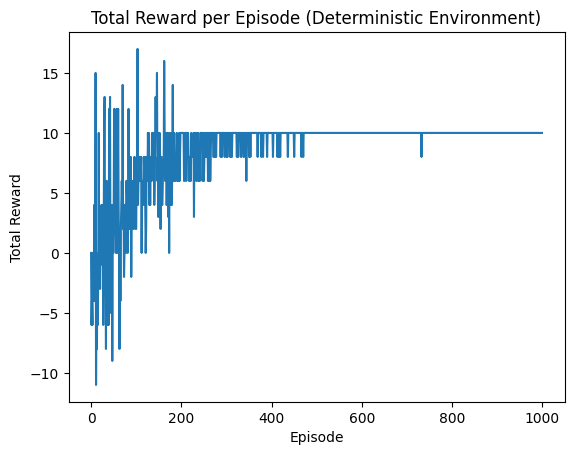

In [16]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

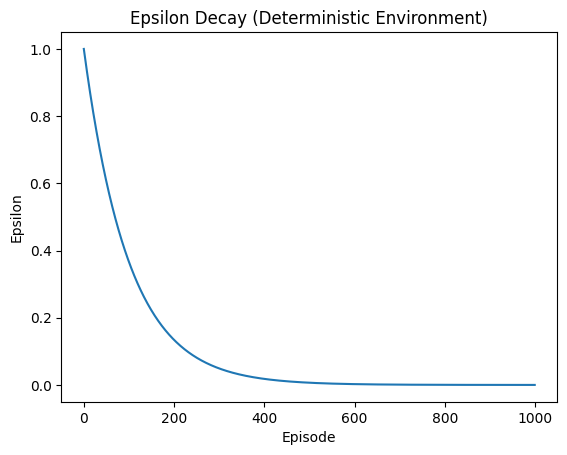

In [17]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

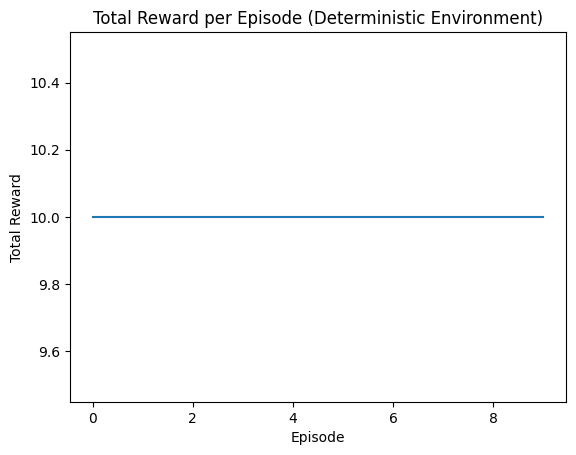

In [18]:
# Run your environment for at least 10 episodes, where the agent chooses only greedy actions from the learned policy
agent.epsilon = 0
reward_per_episode, _ = agent.train(10)

# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [19]:
def q_learning_with_hyperparameters(env, discount_factor, epsilon_decay_rate, episodes=1000, max_steps=100):
    agent = QLearningAgent(env, gamma=discount_factor, epsilon_decay=epsilon_decay_rate)
    rewards_per_episode = agent.train(num_episodes=episodes)
    return rewards_per_episode

In [20]:
# Hyperparameter tuning for Q-learning agent

discount_factors = [0.7, 0.8, 0.9, 0.95, 0.99]
epsilon_decay_rates = [0.97, 0.98, 0.99, 0.995, 0.999]

# store the rewards per episode for each hyperparameter combination in dataframe
df = pd.DataFrame(columns=['Discount Factor', 'Epsilon Decay Rate', 'Average Reward'])

# loop through all hyperparameter combinations for deterministic environment
for i, discount_factor in enumerate(discount_factors):
    for j, epsilon_decay_rate in enumerate(epsilon_decay_rates):
        rewards = q_learning_with_hyperparameters(d_env, discount_factor, epsilon_decay_rate)
        average_reward = np.mean(rewards)
        df.loc[i*len(epsilon_decay_rates) + j] = [discount_factor, epsilon_decay_rate, average_reward]

# print the dataframe
print(df)
        

    Discount Factor  Epsilon Decay Rate  Average Reward
0              0.70               0.970        4.788167
1              0.70               0.980        4.675500
2              0.70               0.990        4.305498
3              0.70               0.995        3.730835
4              0.70               0.999        1.811652
5              0.80               0.970        4.752667
6              0.80               0.980        4.661000
7              0.80               0.990        4.362998
8              0.80               0.995        4.655835
9              0.80               0.999        1.950152
10             0.90               0.970        4.772667
11             0.90               0.980        4.688000
12             0.90               0.990        4.294998
13             0.90               0.995        3.665335
14             0.90               0.999        2.009152
15             0.95               0.970        4.713167
16             0.95               0.980        4

In [21]:
# get the hyperparameters with the highest average reward
best_hyperparameters = df.loc[df['Average Reward'].idxmax()]
print('Best Hyperparameters: \n', best_hyperparameters)

Best Hyperparameters: 
 Discount Factor       0.990000
Epsilon Decay Rate    0.970000
Average Reward        4.789667
Name: 20, dtype: float64


### Stochastic Environment

In [22]:
# Init q-learning agent for stochastic environment
agent = QLearningAgent(s_env)

In [23]:
# print init q-table for stochastic environment
print(agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [24]:
# Train the agent
reward_per_episode, epsilon_history = agent.train(1000)

# Save the Q-table
agent.save_q_table('q_table_sto.pkl')

# Load the Q-table
agent.load_q_table('q_table_sto.pkl')

In [25]:
# print trained q-table for stochastic environment
print(agent.q_table)

[[ 9.27968405e-01  2.84282652e+00  4.25539209e+00  2.46373221e+00]
 [ 2.23574382e+00  3.77148195e+00  2.70710801e+00  2.56788929e+00]
 [ 5.46191215e-01  1.36448197e+00  1.54460302e+00  4.14425011e+00]
 [ 5.26028558e+00 -3.76363000e-02  7.53059110e-02  1.68340388e-01]
 [-7.99265118e-01  2.18869399e+00  3.84133539e-01  1.18113849e-03]
 [-7.25066724e-01  3.88522912e+00  1.68387552e-01  6.16061438e-01]
 [ 1.41200000e-02 -3.05352221e-01  6.28866637e+00  2.49176901e-01]
 [ 8.68119578e+00 -1.09247890e-01  7.69532790e-01 -1.02716593e-02]
 [-3.93721634e-01 -1.63836029e-01 -1.08306466e+00 -4.64607100e-01]
 [-1.14284130e+00 -5.04210284e-02  2.30414261e+00 -6.66081004e-01]
 [-1.00000000e-01  5.90340184e-02  7.71232075e+00 -5.41675442e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


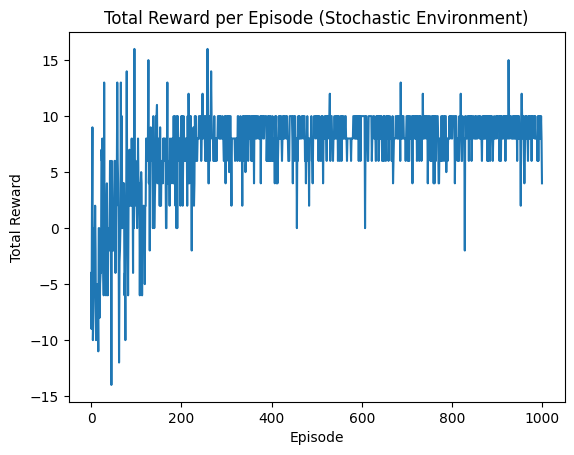

In [26]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Stochastic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

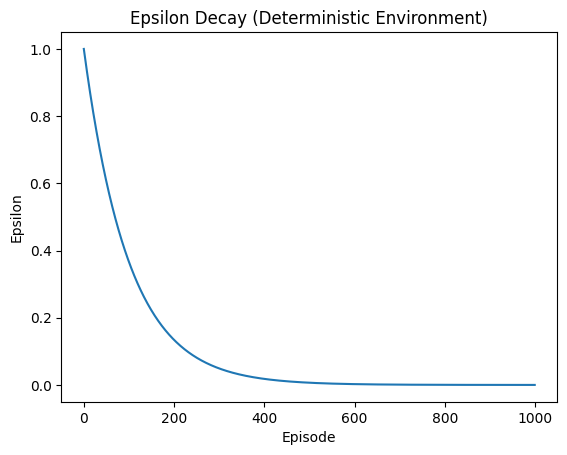

In [27]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [28]:
# Hyperparameter tuning for Q-learning agent

discount_factors = [0.7, 0.8, 0.9, 0.95, 0.99]
epsilon_decay_rates = [0.97, 0.98, 0.99, 0.995, 0.999]

# store the rewards per episode for each hyperparameter combination in dataframe
df = pd.DataFrame(columns=['Discount Factor', 'Epsilon Decay Rate', 'Average Reward'])

# loop through all hyperparameter combinations for stochastic environment
for i, discount_factor in enumerate(discount_factors):
    for j, epsilon_decay_rate in enumerate(epsilon_decay_rates):
        rewards = q_learning_with_hyperparameters(s_env, discount_factor, epsilon_decay_rate)
        average_reward = np.mean(rewards)
        df.loc[i*len(epsilon_decay_rates) + j] = [discount_factor, epsilon_decay_rate, average_reward]

# print the dataframe
print(df)
        

    Discount Factor  Epsilon Decay Rate  Average Reward
0              0.70               0.970        4.107667
1              0.70               0.980        3.962000
2              0.70               0.990        3.747998
3              0.70               0.995        3.741335
4              0.70               0.999        1.080652
5              0.80               0.970        4.051667
6              0.80               0.980        3.994000
7              0.80               0.990        3.682998
8              0.80               0.995        4.538835
9              0.80               0.999        1.153152
10             0.90               0.970        4.073667
11             0.90               0.980        3.990500
12             0.90               0.990        3.604498
13             0.90               0.995        3.034335
14             0.90               0.999        1.233152
15             0.95               0.970        4.082167
16             0.95               0.980        3

In [29]:
# get the hyperparameters with the highest average reward
best_hyperparameters = df.loc[df['Average Reward'].idxmax()]
print('Best Hyperparameters: \n', best_hyperparameters)

Best Hyperparameters: 
 Discount Factor       0.800000
Epsilon Decay Rate    0.995000
Average Reward        4.538835
Name: 8, dtype: float64
